# Import the needed includes

In [36]:
from commonfunctions import *
from classifiers import *
from stemRemoval import stemRemoval
import numpy as np
from staffLine import *
import shutil
import sys
import argparse
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get the input folder name and create the output folder provided its path

In [37]:
inputImagesDirectory = './dataset/test'
directory = os.fsencode(inputImagesDirectory)
inputImages = []
filenames = []
outputDirectory = './outputs'
# checking if input doesn't exist


# reading all images in input folder 

In [39]:
 for file in os.listdir(directory):
    filename = os.fsdecode(file)
    filenames.append(os.path.splitext(filename)[0])
    image = img_as_ubyte(io.imread(os.path.join(
        inputImagesDirectory, filename), as_gray=True))
    inputImages.append(image)

# applying pipeline to all images  

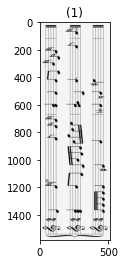

In [40]:
imageIndex = 0
imgOutput = []
img = inputImages[imageIndex]
show_images([img])

# Pre-Analysis

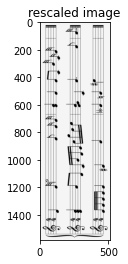

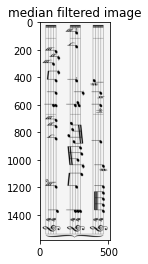

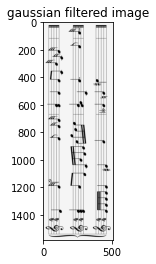

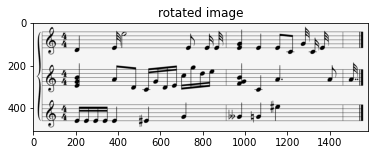

In [41]:
height, width = img.shape
scaleFactor = min(1800/height, 1800/width)
if scaleFactor < 1:
    img = rescale(img, scaleFactor, anti_aliasing=False)
show_images([img], ['rescaled image'])

if img.dtype != 'uint8':
    img = (img*255).astype('uint8')
img_median_filtered = hybridMedian(img).astype('uint8')
show_images([img_median_filtered], ['median filtered image'])

# gaussian filtering
img_gaussian_filtered = gaussian(img_median_filtered, sigma=0.2)
img_gaussian_filtered = (img_gaussian_filtered * 255).astype(np.uint8)
show_images([img_gaussian_filtered], ['gaussian filtered image'])

# image rotation
image_rotated = skew_angle_hough_transform(img_gaussian_filtered)
image_rotated = (image_rotated * 255).astype(np.uint8)
show_images([image_rotated], ['rotated image'])

# Segmentation

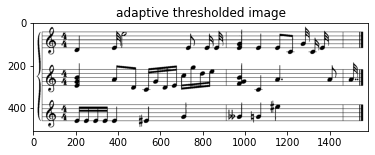

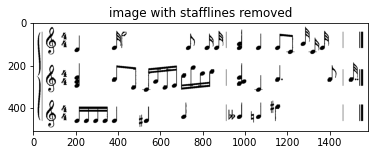

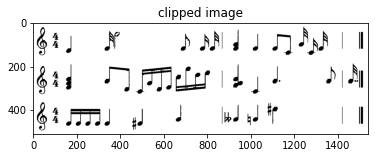

In [42]:
# image binarization
binary = adaptiveThresh(image_rotated, t=15, div=8)
show_images([binary], ['adaptive thresholded image'])

# removing stafflines
img_staffLines_removed, staffLines, staffLineSpacing, staffHeight = staffLineRemoval(
    binary, 1)
show_images([img_staffLines_removed], ['image with stafflines removed'])

# clipping the unnecessary part before the real music score
start_x = get_start_x(binary, len(staffLines), staffHeight)
binary_clipped = binary[:, start_x:img_staffLines_removed.shape[1]]
img_staffLines_removed_clipped = img_staffLines_removed[:,
                                                        start_x:img_staffLines_removed.shape[1]]
show_images([img_staffLines_removed_clipped], ['clipped image'])
# split each object in the score to be identified
objects = split_objects(
    binary_clipped, img_staffLines_removed_clipped, staffLines)


# if the score had multiple groups we divide them into blocks that have 5 stafflines
sameBlock = objects[0][2]

# each block has different pitches coordinates
pitches, pitches_coord = getPitchesCoordinates(
    staffLineSpacing, staffLines, sameBlock)
imgOutput.append([])
accidentals = ""
number = 0
two = False


# Classification

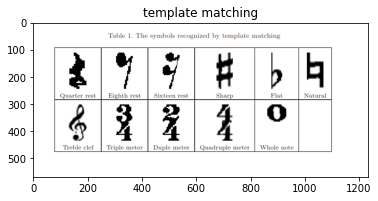

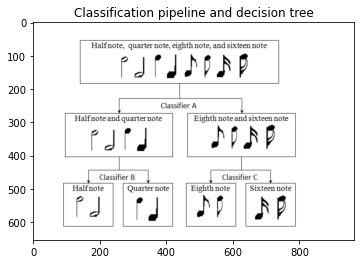

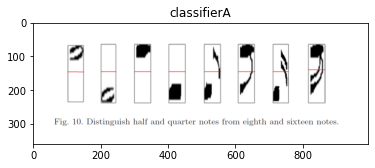

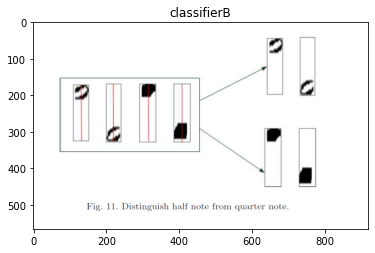

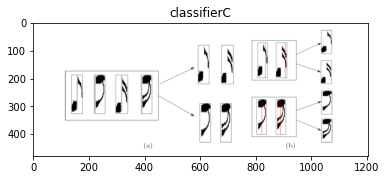

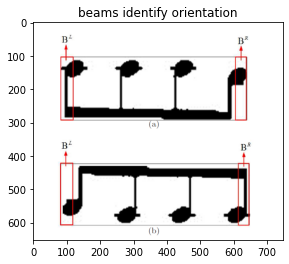

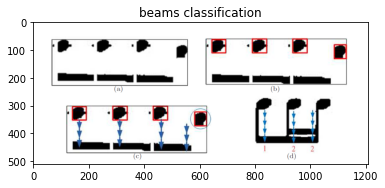

In [43]:

templates = read_all_templates()


tmpmtching = io.imread('./tmpmatching.PNG')
beamses = io.imread('./Beams.PNG')
beamses2 = io.imread('./beams2.PNG')
classes = io.imread('./classifiers.PNG')
classesa = io.imread('./ClassifierA.PNG')
classesb = io.imread('./classifierb.PNG')
classesc = io.imread('./classifierc.PNG')
show_images([tmpmtching], ['template matching'])
show_images([classes], ['Classification pipeline and decision tree'])
show_images([classesa], ['classifierA'])
show_images([classesb], ['classifierB'])
show_images([classesc], ['classifierC'])
show_images([beamses], ['beams identify orientation'])
show_images([beamses2], ['beams classification'])



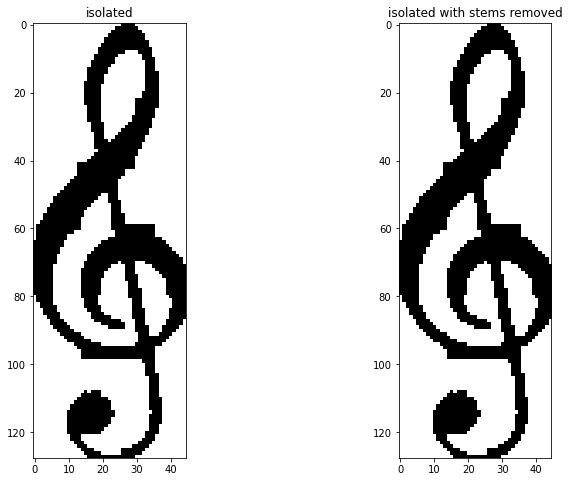

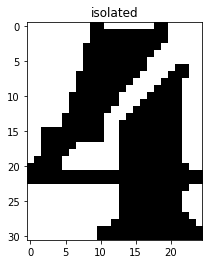

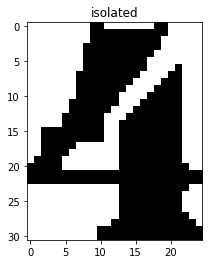

\meter<"4/4">


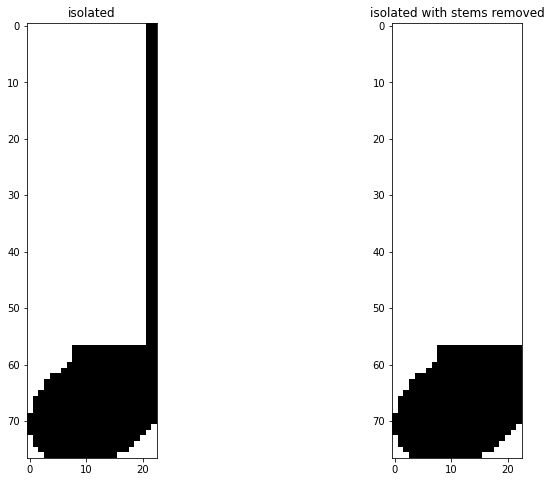


d1/4


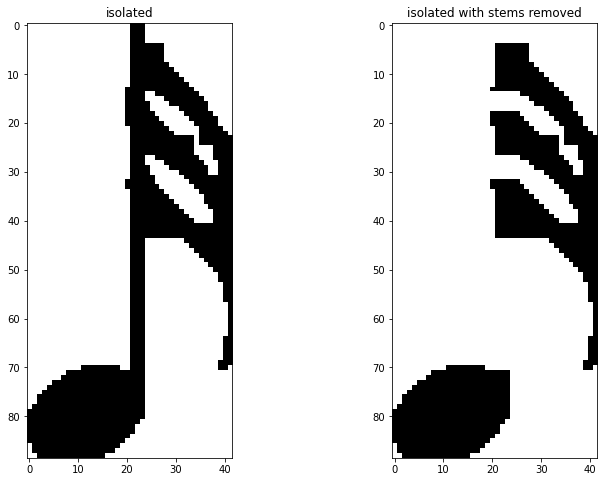


e1/32


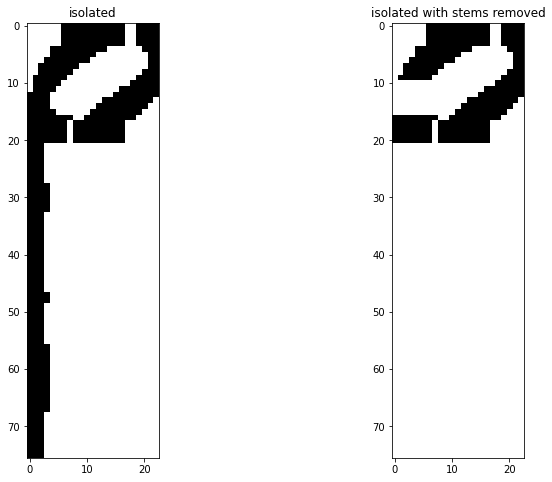


e2/2


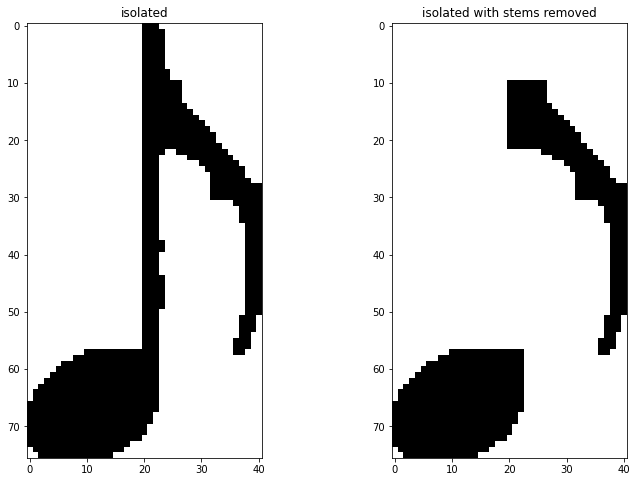


e1/8


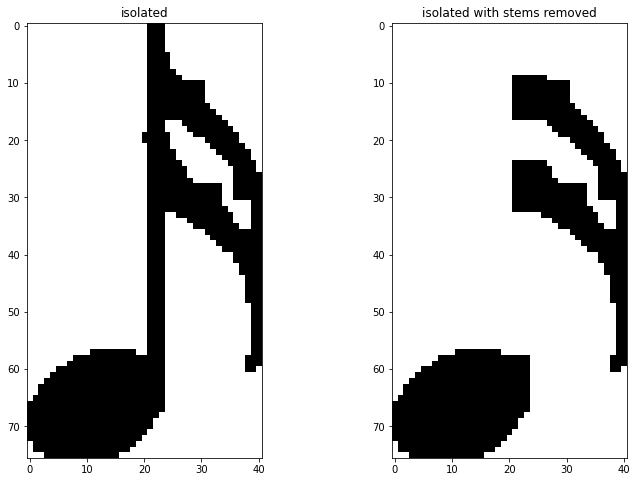


e1/16


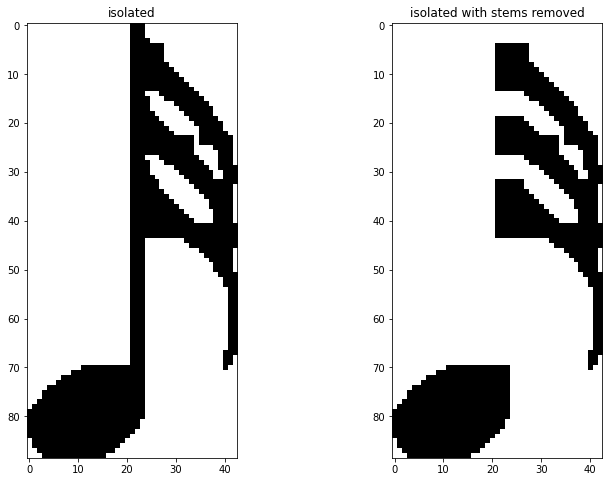


e1/32


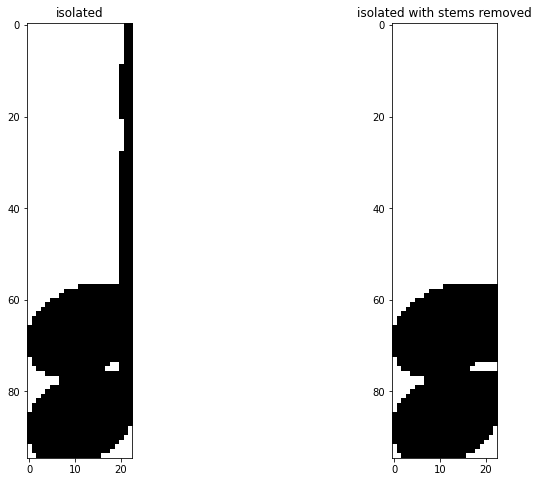

{e1/4,g1/4}


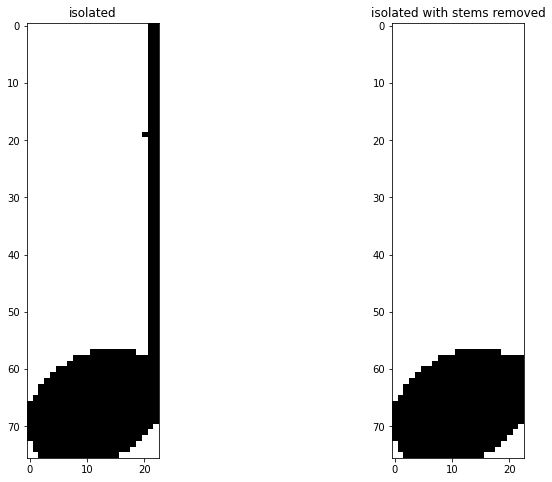


e1/4


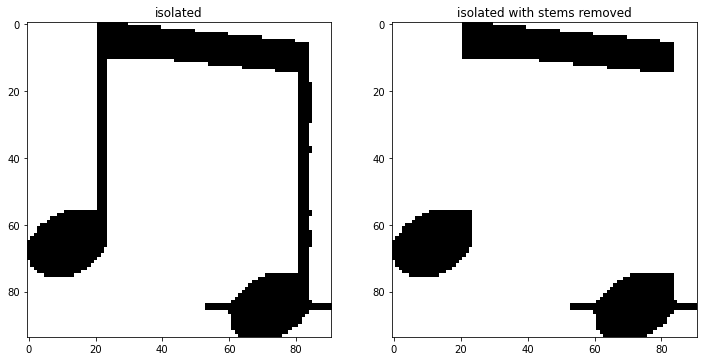

['e1/8', 'c1/8']


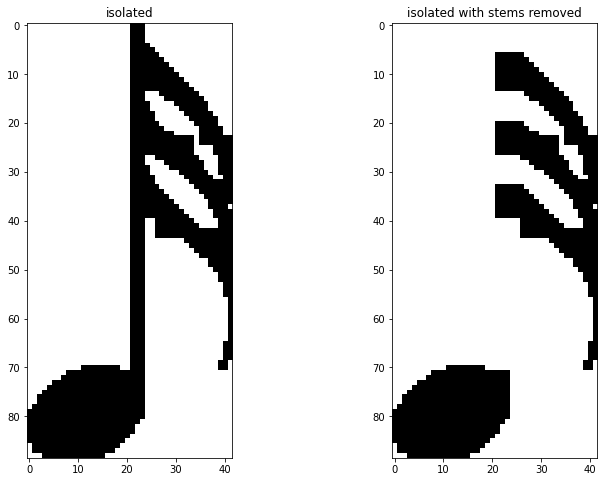


g1/32


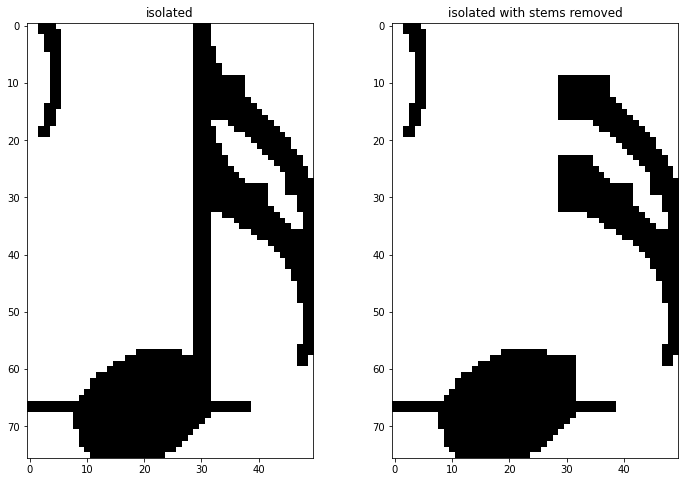


c1/16


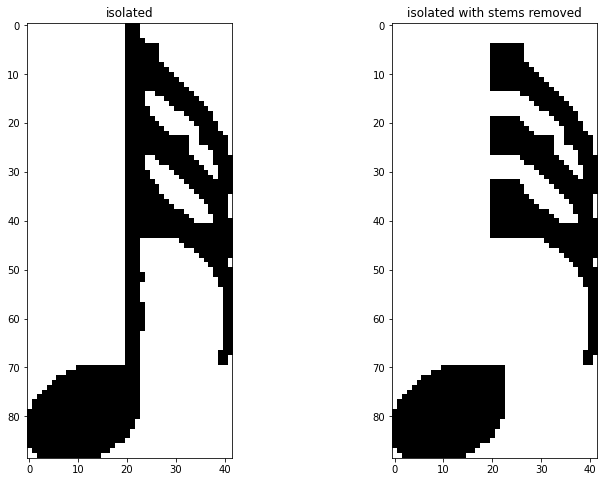


e1/32


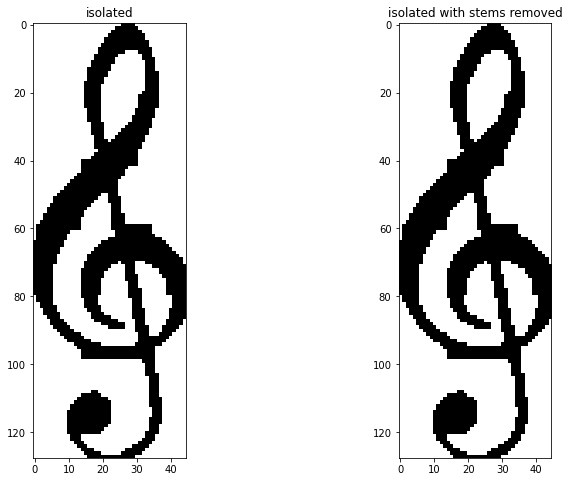

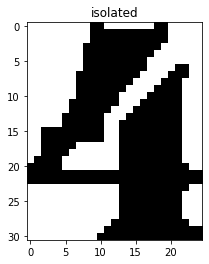

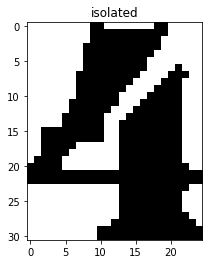

\meter<"4/4">


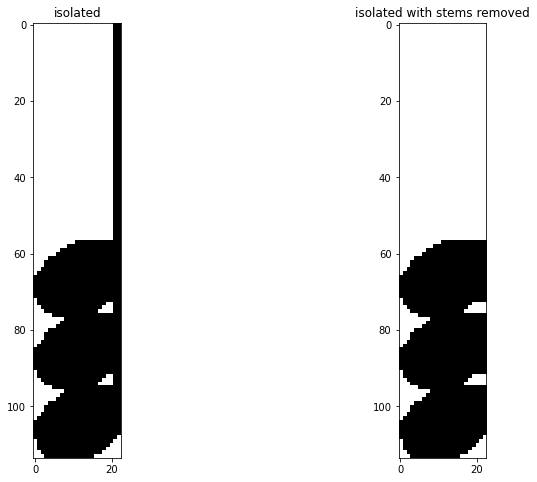

{b1/4,e1/4,g1/4}


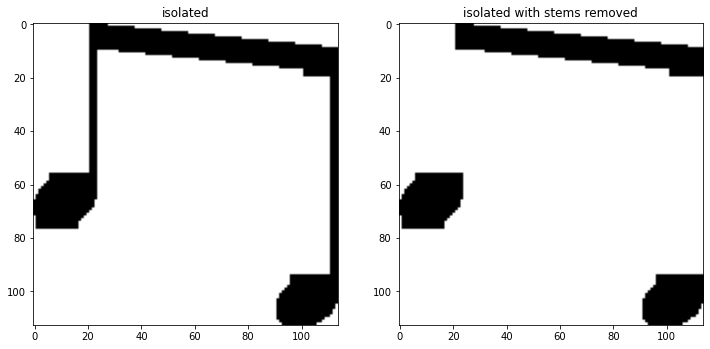

['a1/8', 'd1/8']


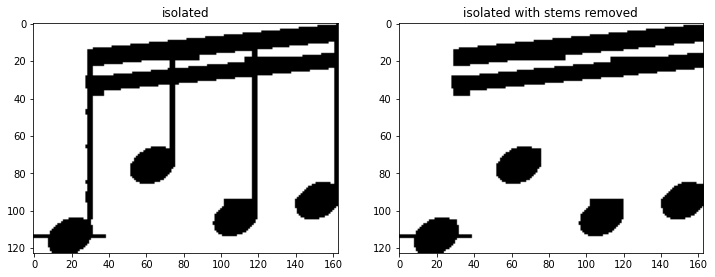

['c1/16', 'g1/16', 'd1/16', 'e1/16']


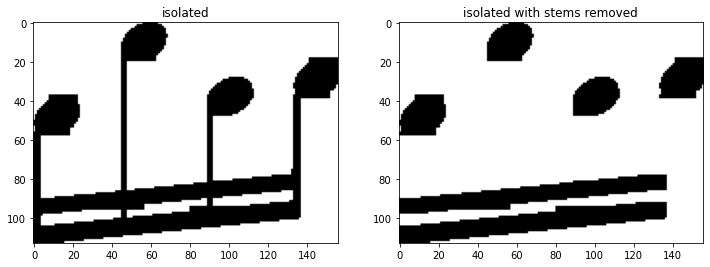

['c2/16', 'g2/16', 'd2/16', 'e2/16']


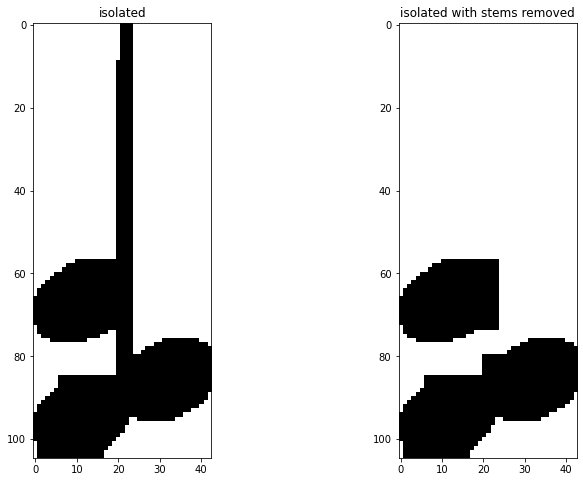

{b1/4,f1/4,g1/4}


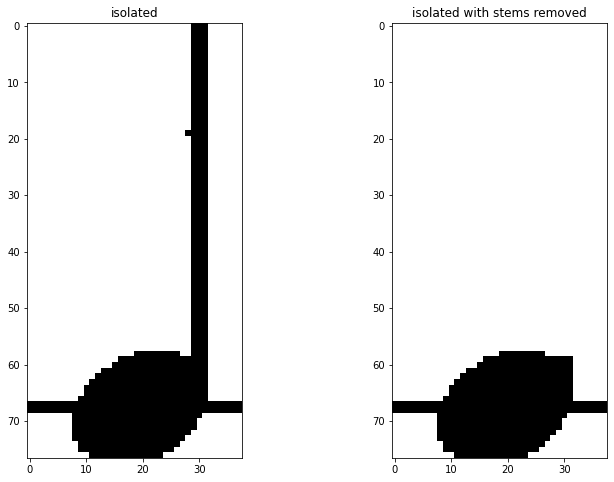


c1/4


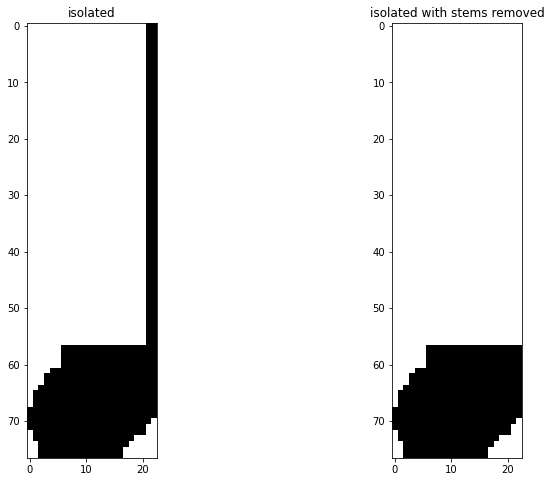


a1/4.


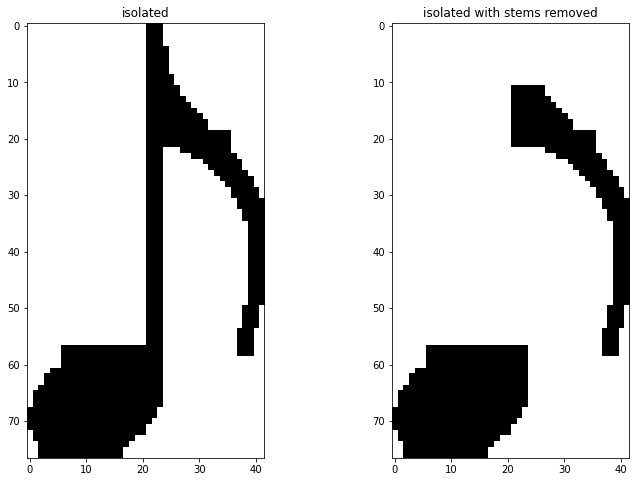


a1/8


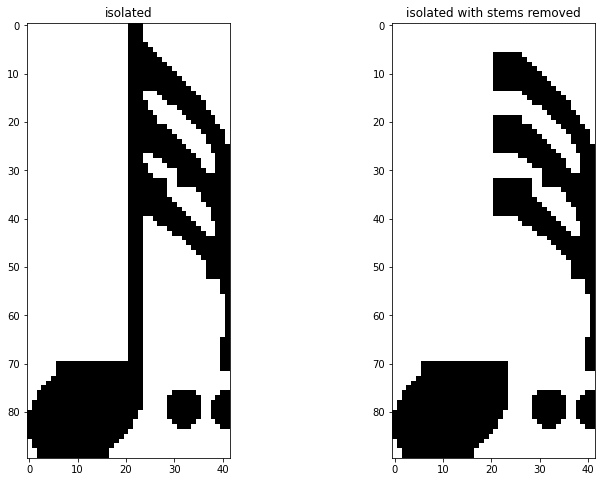


a1/32..


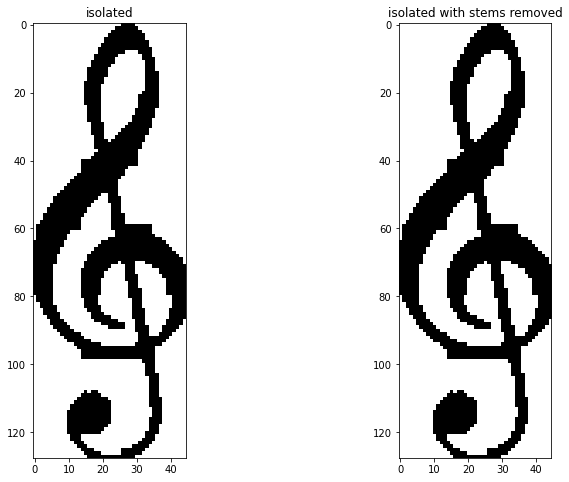

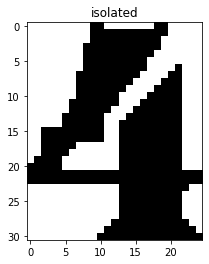

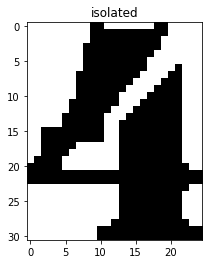

\meter<"4/4">


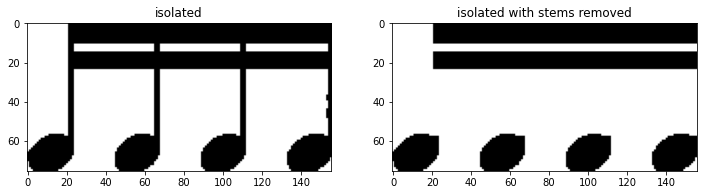

['e1/16', 'e1/16', 'e1/16', 'e1/16']


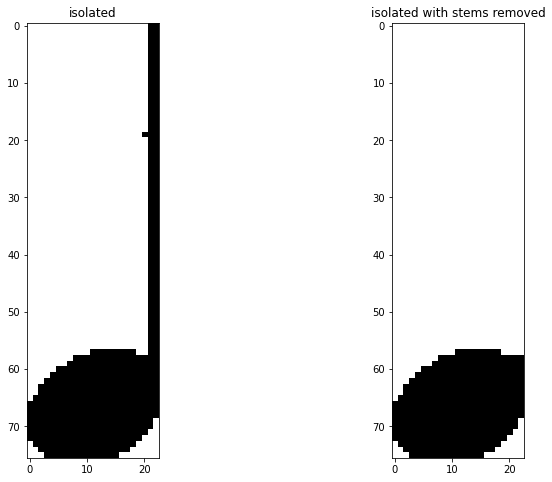


e1/4


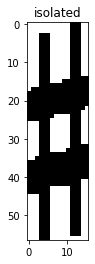

e1/4


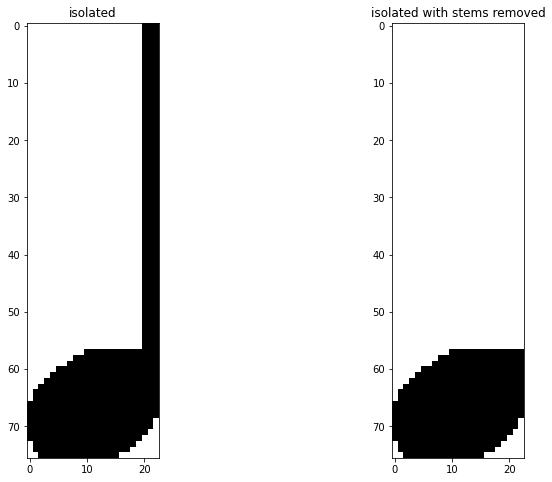


e#1/4


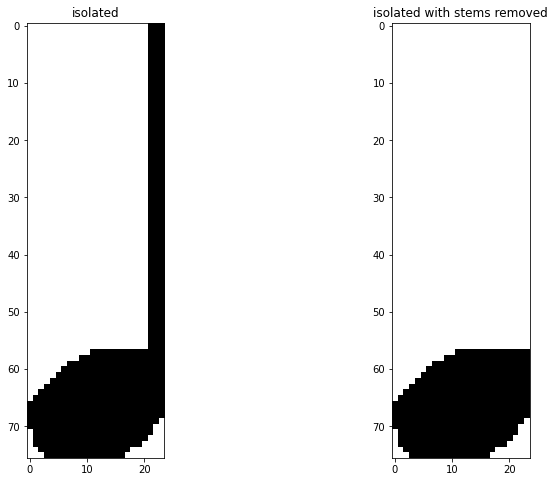


g1/4


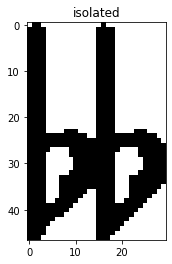

g1/4


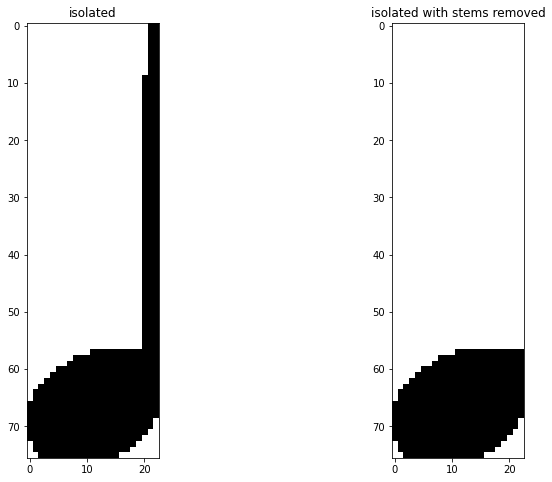


g&&1/4


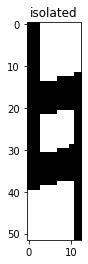

g&&1/4


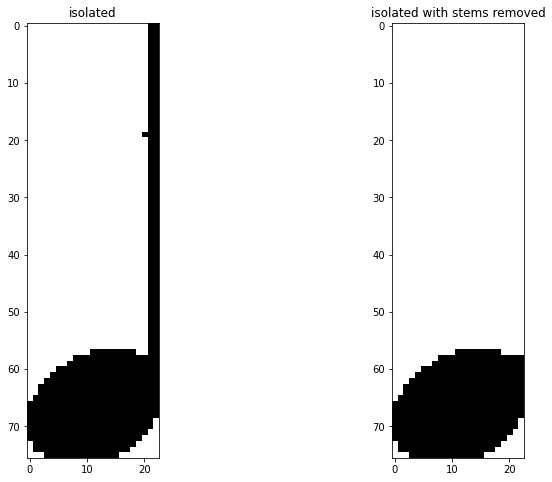


g1/4


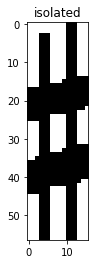

g1/4


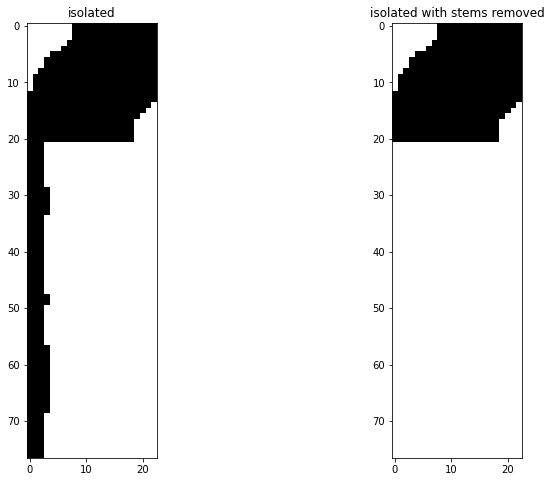


e#2/4


In [44]:
for object, top, blockNumber, dots in objects:
    try:
        # if the we entered a new block recalculte the pitches coordinates
        if sameBlock != blockNumber:
            imgOutput.append([])
            sameBlock = blockNumber
            pitches, pitches_coord = getPitchesCoordinates(
                staffLineSpacing, staffLines, blockNumber)
        # classify the relatively short symbols using SIFT
        if len(object) < 3.5*staffLineSpacing:
            show_images([object], ['isolated'])
            objectLabel, objectType = classify_accidentals(
                (object, top, blockNumber), templates, staffLineSpacing)
            if objectType == "accidental":
                accidentals += objectLabel
            if objectLabel == 'full_note':
                pitch = pitches[find_nearest(
                    pitches_coord, top + len(object)/2)]
                objectLabel = pitch[0] + accidentals + pitch[1] + '/1'
                accidentals = ''
                objectLabel = objectLabel + '.' * dots
                imgOutput[-1].append(objectLabel)
            if objectType == "number":
                number = number + 1
                if objectLabel == "2":
                    two = True
            if number == 2:
                if two == True:
                    imgOutput[-1].append('\meter<"4/2">')
                else:
                    imgOutput[-1].append('\meter<"4/4">')
                two = False
                number = 0
            print(imgOutput[-1][-1])
            continue
        objectWithouStem, stems = stemRemoval(object, staffLineSpacing)
        show_images([object, objectWithouStem], ['isolated', 'isolated with stems removed'])
        if len(stems) == 0:
            continue
        elif len(stems) == 1:
            note = ChordsClassifier(
                objectWithouStem, top, staffLineSpacing, pitches, pitches_coord)
            print(note)
            if note != '':
                imgOutput[-1].append(note)
                continue
            note = classifierA(objectWithouStem, stems, staffLineSpacing,
                            staffHeight, top, pitches, pitches_coord, dots, accidentals)
            if note != '':
                imgOutput[-1].append(note)
                accidentals = ""
            print(note)
        else:
            if chordOrBeamCheck(objectWithouStem) == 'chord':
                note = ChordsClassifier(
                    object, top, staffLineSpacing, pitches, pitches_coord)
                if note != '':
                    imgOutput[-1].append(note)
                print(note)
            else:
                notes = beamClassifier(object, objectWithouStem, staffLineSpacing,
                                    staffHeight, top, pitches, pitches_coord, stems)
                imgOutput[-1].extend(notes)
                print(notes)
    except:
        pass

In [45]:
if outputDirectory[-1] == '/':
    outputFileName = outputDirectory + filenames[imageIndex] + '.txt'
else:
    outputFileName = outputDirectory + '/' + filenames[imageIndex] + '.txt'
writeOutput(outputFileName, imgOutput)